In [1]:
!nvidia-smi

Sat Apr 24 17:30:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!cat /proc/uptime | awk '{print $1 /60 /60 /24 "days (" $1 "sec)"}'

0.0103127days (891.02sec)


In [3]:
!git clone https://github.com/yours-schnee/custom_ImageNet.git

Cloning into 'custom_ImageNet'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 61 (delta 21), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (61/61), done.


In [4]:
!pip install -e ./custom_ImageNet

ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /content/custom_ImageNet


In [5]:
import sys
sys.path.append('/content/custom_ImageNet')

In [6]:
import custom_ImageNet
from utils.ImageNetDataset import make_path_list
from utils.ImageNetDataset import str_convert
from utils.ImageNetDataset import ImageNetDataset

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import init
from torch.optim import lr_scheduler
from torch import optim

In [8]:
import glob
import os
import time
import shutil
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.autonotebook import tqdm

from torchvision import transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.metrics import classification_report
import statistics
import itertools
np.set_printoptions(threshold=np.inf)
#from PIL import Image  
import PIL
import PIL.Image
from PIL import ImageFile

import random

#import copy
from copy import deepcopy
from torchsummary import summary
import torch.utils.data as data
import datetime

!pip install tensorboardX
import tensorboardX as tbx
from tensorboardX import SummaryWriter


     |████████████████████████████████| 122kB 9.0MB/s 


In [9]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
!cp "drive/My Drive/ImageNet/retina_original_ImagenetTrain.zip" /content/
!cp "drive/My Drive/ImageNet/retina_original_ImagenetTest.zip" /content/

In [12]:
!apt-get install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [13]:
!7z x retina_original_ImagenetTrain.zip
!mv "content/retina_ImagenetTrain" ../content/


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 305957198 bytes (292 MiB)

Extracting archive: retina_original_ImagenetTrain.zip
 23% 4096 Open              --
Path = retina_original_ImagenetTrain.zip
Type = zip
Physical Size = 305957198

  0%      3% 612 - content/retina_ImagenetTrain/bird/bird_329.jpg                                                           5% 1058 - content/retina_ImagenetTrain/pineapple/pineapple_686.jpg                                                                    

In [14]:
!7z x retina_original_ImagenetTest.zip
!mv "content/retina_ImagenetTest" ../content/


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 34489251 bytes (33 MiB)

Extracting archive: retina_original_ImagenetTest.zip
--
Path = retina_original_ImagenetTest.zip
Type = zip
Physical Size = 34489251

  0%     41% 850 - content/retina_ImagenetTest/bell_pepper/bell_pepper_044.jpg                                                                       71% 1466          97% 1970 - content/retina_ImagenetTest/cat/cat_041.jpg                                                       Everything is O

In [15]:
import shutil

directory = 'content'

try:
    shutil.rmtree(directory)
except FileNotFoundError:
    pass

In [16]:
def make_path_list_png(rootpath):
    """
    To create the list of file path about Image data and annotation data
    for training and test

    Inputs
    --------------------
    rootpath : str
        path data for data folder

    Returns
    --------------------
    *_img_list, *_anno_list
        list of path for each data
    """

    img_list = glob.glob(rootpath+'*/*.png')

    return img_list

In [17]:
rootpathTrain ='retina_ImagenetTrain/'
rootpathTest ='retina_ImagenetTest/'

# Get folder name
train_img_list = make_path_list(rootpathTrain)
test_img_list = make_path_list(rootpathTest)

In [18]:
len(train_img_list)

17696

In [19]:
simple_transform = transforms.Compose([transforms.Resize((224,224),interpolation=3),
                                       transforms.ToTensor()])

train_dataset = ImageNetDataset(train_img_list, phase="train", transform=simple_transform)

test_dataset = ImageNetDataset(test_img_list, phase="test",
                          transform=simple_transform)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [20]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


In [21]:
# random seed fixed func from github
seed_everything(123)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
classes_list = train_dataset.get_label_relation()

batch_size = 32

In [22]:
len(train_dataset)

17696

In [23]:
# training data split to train and val
validation_split = .2

dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]

# Creating PT data samplers
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

In [24]:
# dataloder
trainloader = data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)

valloader = data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=2)

#trainloader = data.DataLoader(
#    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

testloader = data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

dataloaders_dict = {"train": trainloader, "val": valloader}

In [25]:
index_dict = {"train": train_idx, "val": valid_idx}
len(index_dict["train"])

14157

In [26]:
"""cnt = 0
for epoch in range(2):
    for images, labels in tqdm(testloader):
        cnt += 1
        if (cnt%10)
        print()"""

'cnt = 0\nfor epoch in range(2):\n    for images, labels in tqdm(testloader):\n        cnt += 1\n        if (cnt%10)\n        print()'

--------------------
(224, 224, 3)


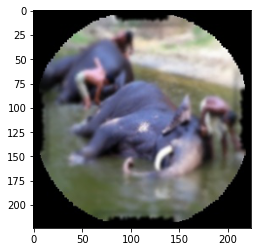

In [27]:
index = 2
imges, label = train_dataset.__getitem__(index)

img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
print("--------------------")
print(img_val.shape)
plt.imshow(img_val)
plt.show()


In [28]:
#code adapted from https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion(cm, classes, name, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    #print(cm)
    filename= name + "_confusion.png"
    path = F"/content/drive/My Drive/Colab Notebooks/Graphs/"
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.0f}".format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(path+filename)


In [29]:
def plot_graph(training_losses,val_losses,epochs,string,name):
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel(string)

    filename = name + "_" + string + "_.png" 
    path = F"/content/drive/My Drive/Colab Notebooks/Graphs/{filename}"
    plt.title(string + 'per epoch - ' + "Simple classifier")
    
    plt.plot(range(epochs),training_losses,label="Training " + string)
    plt.plot(range(epochs),val_losses,label="Validation " + string)
    plt.legend()
    plt.savefig(path+filename)
    print(path+filename)

In [30]:
# This function will test mask image generation, not the difference between original and generated images
  
def test_model(model, criterion, name):

    model.eval()
    test_epoch_loss = 0
    test_correct = 0
    best_accuracy = 0
    class_correct = list(0 for i in range(N_CLASSES))
    class_total = list(0 for i in range(N_CLASSES))
    mean_accuracies = list(0 for i in range(n_iterations))
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    labelslist=torch.zeros(0,dtype=torch.long, device='cpu')

    with torch.no_grad():
        accuracies = [[] for i in range(n_iterations)]
        #for index,(images, anno, labels) in enumerate(testloader):
        for index,(images, labels) in enumerate(testloader):
            images, labels = images.cuda(), labels.cuda()

            predicted = model(images)
            loss = criterion(predicted,labels)

            test_epoch_loss += loss.item()

            best_predicted = predicted
            _, predicted_l = torch.max(best_predicted.data, 1)
            test_correct += (predicted_l == labels).sum().item()
            c = (predicted_l == labels).squeeze()

            predlist=torch.cat([predlist,predicted_l.view(-1).cpu()])
            labelslist=torch.cat([labelslist,labels.view(-1).cpu()])

            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    test_epoch_loss /= len(testloader)
    print('\nTest loss: {:.4f} \nTesting Accuracy: {}/{} ({:.2f}%)'.format(
          test_epoch_loss, test_correct, len(testloader.dataset),
          100. * test_correct / len(testloader.dataset)))
    for i in range(N_CLASSES):
        print("{} Class Accuracy: {}/{} ({:.2f}%)".format(classes_list[i],class_correct[i],class_total[i],100*class_correct[i]/class_total[i]))

    precision = precision_score(predlist.numpy(), labelslist.numpy(), average='macro')
    recall = recall_score(predlist.numpy(), labelslist.numpy(), average='macro')
    accuracy = accuracy_score(predlist.numpy(), labelslist.numpy())
    f1 = fbeta_score(predlist.numpy(), labelslist.numpy(), 1, average='macro') #1 means f_1 measure
    print("Classifier has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (accuracy,precision,recall,f1))
    conf_matrix=confusion_matrix(labelslist.numpy(), predlist.numpy())
    plt.figure(figsize=(8, 8))
    plot_confusion(conf_matrix, classes_list, name, 'Confusion matrix')
    print(classification_report(labelslist.numpy(), predlist.numpy(),target_names=classes_list))

    return mean_accuracies

In [48]:
def train_model(model, dataloaders_dict, criterion, optimizer, num_epochs, name, folder_name, debug_mode=False):
    
    log_path = F"/content/drive/My Drive/Colab Notebooks/Log/"
    now = datetime.datetime.now()
    folder = F"{name}"+now.strftime('%Y%m%d_%H%M%S')

    writer = tbx.SummaryWriter(log_path+folder)

    global best_accuracy;
    global training_losses; global val_losses;
    global train_accuracies; global val_accuracies;
    global epochs;
    global stats; global best_model;
    train_loss=0; val_loss=0; train_acc=0; val_acc=0; 
    for epoch in range(epochs,num_epochs):
        epoch = epoch + 1
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')

        # loop for training and validation every epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # training mode
            else:
                model.eval()    # validation mode

            epoch_loss = 0.0    # epoch loss
            epoch_acc = 0       # epoch correct

            #for images, anno, labels in tqdm(dataloaders_dict[phase]):
            for images, labels in tqdm(dataloaders_dict[phase]):
                #images, anno, labels = images.cuda(), anno.cuda(), labels.cuda()
                images, labels = images.cuda(), labels.cuda()
      
                # initialize optimizer
                optimizer.zero_grad()

                # feedforward calc
                with torch.set_grad_enabled(phase == 'train'):
                    predicted = model(images)
                    loss = criterion(predicted, labels)       # loss calc
                    preds = predicted.max(1,keepdim=True)[1]  # label preds

                    if phase == 'train':
                        loss.backward()
                        #if(LOAD_STATE==True)and(epoch==epochs+1):
                        #    optimizer.load_state_dict( checkpoint["optimizer_state_dict"] )
                        optimizer.step()

                    # calc of iter results
                    epoch_loss += loss.item()
                    epoch_acc += preds.eq(labels.view_as(preds)).sum().item()

            #print(epoch_acc)
            epoch_loss = epoch_loss / len(index_dict[phase])
            epoch_acc = epoch_acc / len(index_dict[phase]) *100.
            
            # stats data save
            if phase == 'train':
                training_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
                train_loss=epoch_loss; train_acc=epoch_acc;
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)
                val_loss=epoch_loss; val_acc=epoch_acc;

                # best model save
                if (epoch_acc > best_accuracy) and debug_mode==False:
                    best_accuracy = epoch_acc
                    best_model = deepcopy(model)
                    
                    total_name = name+".tar"
                    path = F"/content/drive/My Drive/Colab Notebooks/Retina_image/{folder_name}/{total_name}"
                    torch.save({"best_model":model.state_dict(),
                                "best_acc":best_accuracy
                                },path)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        if (epoch%4==0)or(epoch%10==0):
            # Colab's disconnection timing while saving data might cause the broken save data against our hope.
            # So, results every epochs will be saved every epochs.
            
            total_name = name+"_epoch"+str(epoch)+".tar"

            path = F"/content/drive/My Drive/Colab Notebooks/Retina_image/{folder_name}/{total_name}"
            torch.save({
                "epoch":epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "train_loss":training_losses,
                "val_loss":val_losses,
                "train_acc":train_accuracies,
                "val_acc":val_accuracies
                }, path)
            
        print('-------------')
        writer.add_scalars('/loss', {'train_loss': train_loss,
                                     'val_loss': val_loss
                                    }, epoch)
      
        writer.add_scalars('/acc', {'train_acc': train_acc,
                                    'val_acc': val_acc
                                    }, epoch)

    print("Lowest training loss", min(training_losses))
    print("Lowest validation loss", min(val_losses))
    print("Highest training accuracy",max(train_accuracies))
    print("Highest validation accuracy",max(val_accuracies))
    print('-------------')

    stats.append(training_losses)
    stats.append(train_accuracies)
    stats.append(val_losses)
    stats.append(val_accuracies)

    return best_model, stats

### Network model

In [49]:
class TinyCNN(nn.Module):
    """
    TinyCNN: https://arxiv.org/abs/1911.06777v1

    fc1, fc2 should be modified for each image size and class num.

    model=TinyCNN()
    model.fc1 = nn.Linear(in_features=128 * FC_H * FC_W, out_features=N_CLASSES)
    model.fc2 = nn.Linear(in_features=100, out_features=N_CLASSES)
    """

    def __init__(self, DROPOUT=False):
        super(TinyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3,   32,  3, 1, 1, bias=False)
        self.conv2 = nn.Conv2d(32,  64,  3, 1, 1, bias=False)
        self.conv3 = nn.Conv2d(64,  128, 3, 1, 1, bias=False)
        self.conv4 = nn.Conv2d(128, 128, 3, 1, 1, bias=False)

        self.relu = nn.ReLU(inplace=False)
        self.pool = nn.MaxPool2d(2)
        
        self.classifier = nn.Sequential(nn.Linear(128 * 14 * 14, 100), nn.Dropout2d(p=0.5), self.relu,
                                  nn.Linear(100, 20), nn.Dropout2d(p=0.4))
        
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant(m.bias, 0)

    def encode(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        return x

    def forward(self, x):
        x = self.encode(x)

        x = x.view(x.size(0),-1)
        x = self.classifier(x)

        return self.relu(x)

### Model preparation

In [84]:
# TinyCNN model instance set
model=TinyCNN()

# FC layer input&output size change
#model.fc1 = nn.Linear(in_features=128 * FC_H * FC_W, out_features=100)
#model.fc2 = nn.Linear(in_features=100, out_features=N_CLASSES)

model.cuda()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


TinyCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Linear(in_features=25088, out_features=100, bias=True)
    (1): Dropout2d(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=20, bias=True)
    (4): Dropout2d(p=0.4, inplace=False)
  )
)

### Optimizer

In [85]:
# Optimization setting
optimizer = optim.SGD(model.parameters(), lr=0.012, momentum=0.9)

### Loss function

In [86]:
# Loss fuc setting
criterion = nn.CrossEntropyLoss()

### CONST data

In [87]:
# for FC layer's input size computation
img_shapes = [224, 224]

DEBUG = False
if DEBUG:
    NUM_EPOCS = 10
else:
    NUM_EPOCS = 50

n_iterations = 50
N_CLASSES = 20
FC_H = img_shapes[0]//2**4 # 4 is max plling layer num
FC_W = img_shapes[1]//2**4

In [88]:
LOAD_STATE = False
EPOCH = 100             # This values need to check the latest tar ffile name with epoch.
name = "04_simple"
folder_name = "simple"

if LOAD_STATE:
    stats=[];
    
    PATH1 =  F"/content/drive/My Drive/Colab Notebooks/Retina_image/{folder_name}/{name}.tar"

    checkpoint = torch.load(PATH1)
    best_model =model
    best_model.load_state_dict( checkpoint["best_model"] )
    best_accuracy = 0#checkpoint["best_acc"]

    # Colab's disconnection timing while saving data might cause the broken save data against our hope.
    # So, results every epochs will be saved every epochs.
    total_name = name+"_epoch"+str(EPOCH)+".tar"
    PATH2 =  F"/content/drive/My Drive/Colab Notebooks/Retina_image/{folder_name}/{total_name}"

    checkpoint = torch.load(PATH2)
    epochs = checkpoint["epoch"]
    model.load_state_dict( checkpoint["model_state_dict"] )

    optimizer.load_state_dict( checkpoint["optimizer_state_dict"] )
    training_losses = checkpoint["train_loss"]; val_losses = checkpoint["val_loss"];
    train_accuracies = checkpoint["train_acc"]; val_accuracies = checkpoint["val_acc"];
    stats.append(training_losses)
    stats.append(train_accuracies)
    stats.append(val_losses)
    stats.append(val_accuracies)

else:
    # start point
    best_model=model;
    best_accuracy = 0;
    training_losses = []; val_losses = [];
    train_accuracies = []; val_accuracies = [];
    stats=[];
    epochs=0;

### Training & Test for model

In [89]:
best_model, stats = train_model(model, dataloaders_dict, criterion, optimizer, NUM_EPOCS, name, folder_name, DEBUG)

Epoch 1/50
-------------



train Loss: 0.0931 Acc: 8.2927



val Loss: 0.0892 Acc: 11.3309
-------------
Epoch 2/50
-------------



train Loss: 0.0908 Acc: 12.0718



val Loss: 0.0888 Acc: 17.1235
-------------
Epoch 3/50
-------------



train Loss: 0.0894 Acc: 14.3604



val Loss: 0.0873 Acc: 19.8926
-------------
Epoch 4/50
-------------



train Loss: 0.0886 Acc: 15.8791



val Loss: 0.0864 Acc: 20.6838
-------------
Epoch 5/50
-------------



train Loss: 0.0874 Acc: 17.3624



val Loss: 0.0847 Acc: 22.5770
-------------
Epoch 6/50
-------------



train Loss: 0.0871 Acc: 18.3513



val Loss: 0.0826 Acc: 26.2221
-------------
Epoch 7/50
-------------



train Loss: 0.0858 Acc: 19.3685



val Loss: 0.0813 Acc: 27.4936
-------------
Epoch 8/50
-------------



train Loss: 0.0851 Acc: 20.5623



val Loss: 0.0844 Acc: 23.1986
-------------
Epoch 9/50
-------------



train Loss: 0.0850 Acc: 20.4563



val Loss: 0.0812 Acc: 27.3806
-------------
Epoch 10/50
-------------



train Loss: 0.0842 Acc: 21.5865



val Loss: 0.0794 Acc: 28.6239
-------------
Epoch 11/50
-------------



train Loss: 0.0838 Acc: 22.1375



val Loss: 0.0787 Acc: 31.5343
-------------
Epoch 12/50
-------------



train Loss: 0.0832 Acc: 23.0557



val Loss: 0.0778 Acc: 32.2973
-------------
Epoch 13/50
-------------



train Loss: 0.0822 Acc: 24.1365



val Loss: 0.0796 Acc: 29.4716
-------------
Epoch 14/50
-------------



train Loss: 0.0820 Acc: 24.6592



val Loss: 0.0791 Acc: 29.8955
-------------
Epoch 15/50
-------------



train Loss: 0.0813 Acc: 25.3090



val Loss: 0.0779 Acc: 33.0319
-------------
Epoch 16/50
-------------



train Loss: 0.0803 Acc: 26.3050



val Loss: 0.0753 Acc: 35.4337
-------------
Epoch 17/50
-------------



train Loss: 0.0796 Acc: 26.9549



val Loss: 0.0752 Acc: 36.9031
-------------
Epoch 18/50
-------------



train Loss: 0.0784 Acc: 28.2828



val Loss: 0.0766 Acc: 32.6081
-------------
Epoch 19/50
-------------



train Loss: 0.0782 Acc: 28.8550



val Loss: 0.0739 Acc: 37.2704
-------------
Epoch 20/50
-------------



train Loss: 0.0779 Acc: 28.8903



val Loss: 0.0755 Acc: 36.8748
-------------
Epoch 21/50
-------------



train Loss: 0.0766 Acc: 30.6068



val Loss: 0.0749 Acc: 36.0554
-------------
Epoch 22/50
-------------



train Loss: 0.0759 Acc: 31.4120



val Loss: 0.0746 Acc: 35.7163
-------------
Epoch 23/50
-------------



train Loss: 0.0746 Acc: 32.7471



val Loss: 0.0723 Acc: 38.0899
-------------
Epoch 24/50
-------------



train Loss: 0.0746 Acc: 32.6058



val Loss: 0.0727 Acc: 38.7398
-------------
Epoch 25/50
-------------



train Loss: 0.0739 Acc: 33.6300



val Loss: 0.0739 Acc: 35.7728
-------------
Epoch 26/50
-------------



train Loss: 0.0729 Acc: 34.4423



val Loss: 0.0738 Acc: 37.5812
-------------
Epoch 27/50
-------------



train Loss: 0.0718 Acc: 35.7350



val Loss: 0.0732 Acc: 39.6440
-------------
Epoch 28/50
-------------



train Loss: 0.0711 Acc: 36.2153



val Loss: 0.0730 Acc: 37.9203
-------------
Epoch 29/50
-------------



train Loss: 0.0693 Acc: 38.4686



val Loss: 0.0741 Acc: 35.7446
-------------
Epoch 30/50
-------------



train Loss: 0.0691 Acc: 38.2779



val Loss: 0.0732 Acc: 38.2594
-------------
Epoch 31/50
-------------



train Loss: 0.0687 Acc: 38.5251



val Loss: 0.0729 Acc: 38.5137
-------------
Epoch 32/50
-------------



train Loss: 0.0685 Acc: 38.8218



val Loss: 0.0736 Acc: 36.9031
-------------
Epoch 33/50
-------------



train Loss: 0.0678 Acc: 39.5988



val Loss: 0.0734 Acc: 38.6550
-------------
Epoch 34/50
-------------



train Loss: 0.0671 Acc: 40.0297



val Loss: 0.0740 Acc: 37.4117
-------------
Epoch 35/50
-------------



train Loss: 0.0673 Acc: 39.8107



val Loss: 0.0738 Acc: 36.3097
-------------
Epoch 36/50
-------------



train Loss: 0.0659 Acc: 41.3082



val Loss: 0.0731 Acc: 37.7225
-------------
Epoch 37/50
-------------



train Loss: 0.0660 Acc: 41.2517



val Loss: 0.0749 Acc: 35.8576
-------------
Epoch 38/50
-------------



train Loss: 0.0655 Acc: 41.6896



val Loss: 0.0748 Acc: 35.0381
-------------
Epoch 39/50
-------------



train Loss: 0.0655 Acc: 41.9934



val Loss: 0.0750 Acc: 36.1684
-------------
Epoch 40/50
-------------



train Loss: 0.0646 Acc: 42.5231



val Loss: 0.0753 Acc: 37.1009
-------------
Epoch 41/50
-------------



train Loss: 0.0640 Acc: 42.9116



val Loss: 0.0735 Acc: 37.9203
-------------
Epoch 42/50
-------------



train Loss: 0.0644 Acc: 42.9681



val Loss: 0.0730 Acc: 37.9486
-------------
Epoch 43/50
-------------



train Loss: 0.0645 Acc: 42.8269



val Loss: 0.0767 Acc: 34.3317
-------------
Epoch 44/50
-------------



train Loss: 0.0640 Acc: 43.2224



val Loss: 0.0755 Acc: 35.8011
-------------
Epoch 45/50
-------------



train Loss: 0.0644 Acc: 42.9964



val Loss: 0.0756 Acc: 35.6315
-------------
Epoch 46/50
-------------



train Loss: 0.0635 Acc: 43.3708



val Loss: 0.0764 Acc: 36.0554
-------------
Epoch 47/50
-------------



train Loss: 0.0628 Acc: 44.1336



val Loss: 0.0746 Acc: 36.5640
-------------
Epoch 48/50
-------------



train Loss: 0.0621 Acc: 44.9177



val Loss: 0.0758 Acc: 36.1684
-------------
Epoch 49/50
-------------



train Loss: 0.0622 Acc: 45.1791



val Loss: 0.0767 Acc: 35.4903
-------------
Epoch 50/50
-------------



train Loss: 0.0628 Acc: 43.9359



val Loss: 0.0752 Acc: 36.1684
-------------
Lowest training loss 0.06208496546100289
Lowest validation loss 0.07231890855451262
Highest training accuracy 45.17906336088154
Highest validation accuracy 39.6439672223792
-------------


/content/drive/My Drive/Colab Notebooks/Graphs/04_simple_Loss _.png04_simple_Loss _.png
/content/drive/My Drive/Colab Notebooks/Graphs/04_simple_Accuracy _.png04_simple_Accuracy _.png


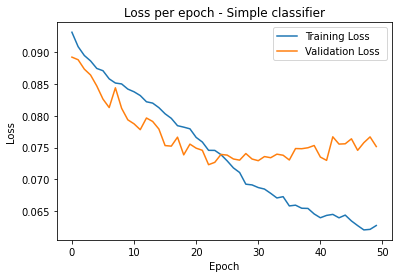

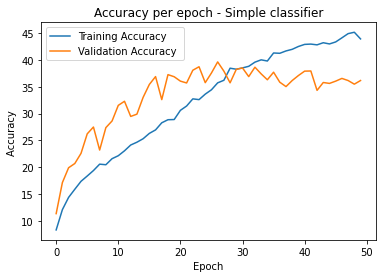

In [90]:
plt.rcParams["figure.figsize"] = (6,4)
plot_graph(stats[0],stats[2],NUM_EPOCS,"Loss ",name)
plot_graph(stats[1],stats[3],NUM_EPOCS,"Accuracy ",name)


Test loss: 2.3941 
Testing Accuracy: 727/2000 (36.35%)
apple Class Accuracy: 23/100 (23.00%)
banana Class Accuracy: 31/100 (31.00%)
bear Class Accuracy: 47/100 (47.00%)
bell_pepper Class Accuracy: 19/100 (19.00%)
bird Class Accuracy: 20/100 (20.00%)
broccoli Class Accuracy: 47/100 (47.00%)
cat Class Accuracy: 44/100 (44.00%)
cauliflower Class Accuracy: 0/100 (0.00%)
cow Class Accuracy: 54/100 (54.00%)
dog Class Accuracy: 9/100 (9.00%)
elephant Class Accuracy: 68/100 (68.00%)
fox Class Accuracy: 35/100 (35.00%)
goat Class Accuracy: 28/100 (28.00%)
horse Class Accuracy: 30/100 (30.00%)
mashed_potato Class Accuracy: 31/100 (31.00%)
orange Class Accuracy: 62/100 (62.00%)
pineapple Class Accuracy: 21/100 (21.00%)
pomegranate Class Accuracy: 71/100 (71.00%)
tomato Class Accuracy: 21/100 (21.00%)
zebra Class Accuracy: 66/100 (66.00%)
Classifier has Acc=0.363 P=0.364 R=0.359 F1=0.346


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

        apple       0.22      0.23      0.23       100
       banana       0.34      0.31      0.32       100
         bear       0.58      0.47      0.52       100
  bell_pepper       0.30      0.19      0.23       100
         bird       0.25      0.20      0.22       100
     broccoli       0.36      0.47      0.41       100
          cat       0.26      0.44      0.33       100
  cauliflower       0.00      0.00      0.00       100
          cow       0.50      0.54      0.52       100
          dog       0.20      0.09      0.12       100
     elephant       0.28      0.68      0.40       100
          fox       0.45      0.35      0.40       100
         goat       0.25      0.28      0.27       100
        horse       0.25      0.30      0.27       100
mashed_potato       0.36      0.31      0.34       100
       orange       0.46      0.62      0.53       100
    pineapple       0.46      0.21      0.29       100
  pomegra

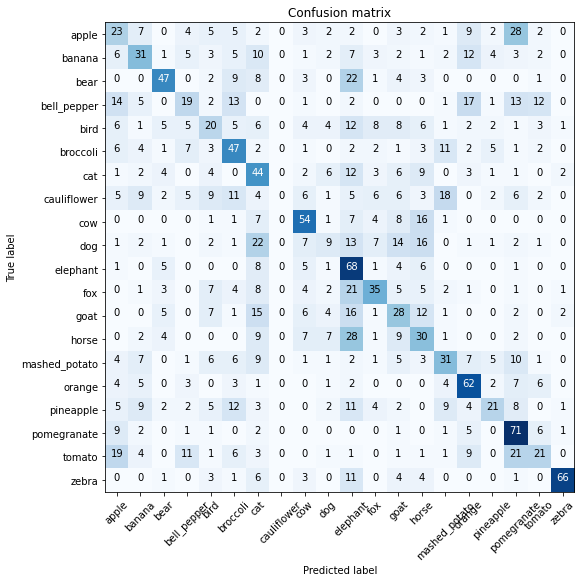

In [91]:
result = test_model(best_model, criterion, name)

In [38]:
best_model, stats = train_model(model, dataloaders_dict, criterion, optimizer, NUM_EPOCS, name, folder_name, DEBUG)

Epoch 1/100
-------------



train Loss: 0.0927 Acc: 10.1081



val Loss: 0.0896 Acc: 18.0559
-------------
Epoch 2/100
-------------



train Loss: 0.0905 Acc: 14.1273



val Loss: 0.0883 Acc: 20.5425
-------------
Epoch 3/100
-------------



train Loss: 0.0888 Acc: 16.6278



val Loss: 0.0866 Acc: 24.1594
-------------
Epoch 4/100
-------------



train Loss: 0.0880 Acc: 17.3907



val Loss: 0.0864 Acc: 24.2159
-------------
Epoch 5/100
-------------



train Loss: 0.0870 Acc: 18.9023



val Loss: 0.0832 Acc: 26.9003
-------------
Epoch 6/100
-------------



train Loss: 0.0859 Acc: 20.0325



val Loss: 0.0819 Acc: 27.9457
-------------
Epoch 7/100
-------------



train Loss: 0.0850 Acc: 21.3605



val Loss: 0.0806 Acc: 30.7431
-------------
Epoch 8/100
-------------



train Loss: 0.0844 Acc: 22.2152



val Loss: 0.0783 Acc: 31.0822
-------------
Epoch 9/100
-------------



train Loss: 0.0832 Acc: 23.4372



val Loss: 0.0783 Acc: 31.0540
-------------
Epoch 10/100
-------------



train Loss: 0.0822 Acc: 24.3696



val Loss: 0.0771 Acc: 34.5295
-------------
Epoch 11/100
-------------



train Loss: 0.0815 Acc: 25.2455



val Loss: 0.0752 Acc: 36.5357
-------------
Epoch 12/100
-------------



train Loss: 0.0810 Acc: 25.7752



val Loss: 0.0747 Acc: 37.4117
-------------
Epoch 13/100
-------------



train Loss: 0.0796 Acc: 27.4776



val Loss: 0.0736 Acc: 38.0899
-------------
Epoch 14/100
-------------



train Loss: 0.0794 Acc: 28.2546



val Loss: 0.0747 Acc: 36.0836
-------------
Epoch 15/100
-------------



train Loss: 0.0785 Acc: 28.9397



val Loss: 0.0734 Acc: 38.8810
-------------
Epoch 16/100
-------------



train Loss: 0.0773 Acc: 30.2960



val Loss: 0.0736 Acc: 39.4179
-------------
Epoch 17/100
-------------



train Loss: 0.0761 Acc: 31.2284



val Loss: 0.0719 Acc: 40.4917
-------------
Epoch 18/100
-------------



train Loss: 0.0750 Acc: 32.8036



val Loss: 0.0717 Acc: 40.4352
-------------
Epoch 19/100
-------------



train Loss: 0.0742 Acc: 33.4534



val Loss: 0.0725 Acc: 40.0961
-------------
Epoch 20/100
-------------



train Loss: 0.0733 Acc: 34.3152



val Loss: 0.0715 Acc: 42.0458
-------------
Epoch 21/100
-------------



train Loss: 0.0724 Acc: 34.9862



val Loss: 0.0711 Acc: 40.4634
-------------
Epoch 22/100
-------------



train Loss: 0.0706 Acc: 37.0206



val Loss: 0.0700 Acc: 40.7177
-------------
Epoch 23/100
-------------



train Loss: 0.0690 Acc: 38.6523



val Loss: 0.0711 Acc: 41.1698
-------------
Epoch 24/100
-------------



train Loss: 0.0685 Acc: 39.2668



val Loss: 0.0708 Acc: 40.0678
-------------
Epoch 25/100
-------------



train Loss: 0.0674 Acc: 39.8036



val Loss: 0.0720 Acc: 39.8135
-------------
Epoch 26/100
-------------



train Loss: 0.0665 Acc: 40.9197



val Loss: 0.0707 Acc: 41.8762
-------------
Epoch 27/100
-------------



train Loss: 0.0649 Acc: 42.0428



val Loss: 0.0725 Acc: 39.4462
-------------
Epoch 28/100
-------------



train Loss: 0.0639 Acc: 43.1871



val Loss: 0.0700 Acc: 41.5937
-------------
Epoch 29/100
-------------



train Loss: 0.0635 Acc: 43.4485



val Loss: 0.0690 Acc: 43.0913
-------------
Epoch 30/100
-------------



train Loss: 0.0623 Acc: 44.2679



val Loss: 0.0701 Acc: 41.5372
-------------
Epoch 31/100
-------------



train Loss: 0.0615 Acc: 45.3345



val Loss: 0.0710 Acc: 41.2546
-------------
Epoch 32/100
-------------



train Loss: 0.0608 Acc: 45.6453



val Loss: 0.0711 Acc: 39.9548
-------------
Epoch 33/100
-------------



train Loss: 0.0600 Acc: 46.5847



val Loss: 0.0722 Acc: 40.1808
-------------
Epoch 34/100
-------------



train Loss: 0.0590 Acc: 47.1216



val Loss: 0.0714 Acc: 40.5199
-------------
Epoch 35/100
-------------



train Loss: 0.0591 Acc: 47.1639



val Loss: 0.0705 Acc: 41.4241
-------------
Epoch 36/100
-------------



train Loss: 0.0577 Acc: 48.0328



val Loss: 0.0699 Acc: 41.5372
-------------
Epoch 37/100
-------------



train Loss: 0.0569 Acc: 48.9369



val Loss: 0.0707 Acc: 41.1981
-------------
Epoch 38/100
-------------



train Loss: 0.0568 Acc: 49.1771



val Loss: 0.0718 Acc: 40.9155
-------------
Epoch 39/100
-------------



train Loss: 0.0564 Acc: 49.5161



val Loss: 0.0723 Acc: 39.9265
-------------
Epoch 40/100
-------------



train Loss: 0.0551 Acc: 50.6746



val Loss: 0.0712 Acc: 41.7915
-------------
Epoch 41/100
-------------



train Loss: 0.0556 Acc: 49.9611



val Loss: 0.0724 Acc: 40.9155
-------------
Epoch 42/100
-------------



train Loss: 0.0559 Acc: 49.8057



val Loss: 0.0714 Acc: 41.7350
-------------
Epoch 43/100
-------------



train Loss: 0.0537 Acc: 51.4021



val Loss: 0.0726 Acc: 38.9093
-------------
Epoch 44/100
-------------



train Loss: 0.0529 Acc: 52.1085



val Loss: 0.0717 Acc: 40.7742
-------------
Epoch 45/100
-------------



train Loss: 0.0540 Acc: 51.2962



val Loss: 0.0725 Acc: 40.9155
-------------
Epoch 46/100
-------------



train Loss: 0.0537 Acc: 51.1478



val Loss: 0.0726 Acc: 40.5199
-------------
Epoch 47/100
-------------



train Loss: 0.0534 Acc: 51.5010



val Loss: 0.0717 Acc: 41.1698
-------------
Epoch 48/100
-------------



train Loss: 0.0533 Acc: 52.1368



val Loss: 0.0724 Acc: 39.8135
-------------
Epoch 49/100
-------------



train Loss: 0.0519 Acc: 52.8714



val Loss: 0.0709 Acc: 42.4131
-------------
Epoch 50/100
-------------



train Loss: 0.0520 Acc: 52.7725



val Loss: 0.0730 Acc: 39.0788
-------------
Epoch 51/100
-------------



train Loss: 0.0514 Acc: 53.1892



val Loss: 0.0723 Acc: 40.5199
-------------
Epoch 52/100
-------------



train Loss: 0.0521 Acc: 52.7654



val Loss: 0.0721 Acc: 41.1698
-------------
Epoch 53/100
-------------



train Loss: 0.0511 Acc: 53.5777



val Loss: 0.0741 Acc: 38.8528
-------------
Epoch 54/100
-------------



train Loss: 0.0515 Acc: 53.1257



val Loss: 0.0721 Acc: 40.8025
-------------
Epoch 55/100
-------------



train Loss: 0.0507 Acc: 53.9662



val Loss: 0.0728 Acc: 40.5482
-------------
Epoch 56/100
-------------



train Loss: 0.0506 Acc: 53.8956



val Loss: 0.0726 Acc: 40.2939
-------------
Epoch 57/100
-------------



train Loss: 0.0506 Acc: 53.7614



val Loss: 0.0726 Acc: 40.7460
-------------
Epoch 58/100
-------------



train Loss: 0.0502 Acc: 54.2700



val Loss: 0.0734 Acc: 40.0113
-------------
Epoch 59/100
-------------



train Loss: 0.0496 Acc: 54.3477



val Loss: 0.0730 Acc: 40.0396
-------------
Epoch 60/100
-------------



train Loss: 0.0502 Acc: 54.3124



val Loss: 0.0723 Acc: 41.0568
-------------
Epoch 61/100
-------------



train Loss: 0.0494 Acc: 55.1035



val Loss: 0.0733 Acc: 39.9265
-------------
Epoch 62/100
-------------



train Loss: 0.0498 Acc: 54.4889



val Loss: 0.0751 Acc: 37.8638
-------------
Epoch 63/100
-------------



train Loss: 0.0499 Acc: 54.7291



val Loss: 0.0738 Acc: 39.8135
-------------
Epoch 64/100
-------------



train Loss: 0.0497 Acc: 54.3547



val Loss: 0.0724 Acc: 41.5089
-------------
Epoch 65/100
-------------



train Loss: 0.0495 Acc: 54.6302



val Loss: 0.0726 Acc: 40.7742
-------------
Epoch 66/100
-------------



train Loss: 0.0493 Acc: 54.6938



val Loss: 0.0739 Acc: 39.5027
-------------
Epoch 67/100
-------------



train Loss: 0.0492 Acc: 54.9975



val Loss: 0.0729 Acc: 40.4917
-------------
Epoch 68/100
-------------



train Loss: 0.0483 Acc: 55.5767



val Loss: 0.0725 Acc: 40.6329
-------------
Epoch 69/100
-------------



train Loss: 0.0486 Acc: 55.5414



val Loss: 0.0729 Acc: 40.4917
-------------
Epoch 70/100
-------------



train Loss: 0.0488 Acc: 54.9340



val Loss: 0.0734 Acc: 39.7570
-------------
Epoch 71/100
-------------



train Loss: 0.0480 Acc: 55.4779



val Loss: 0.0750 Acc: 38.0616
-------------
Epoch 72/100
-------------



train Loss: 0.0488 Acc: 55.1459



val Loss: 0.0745 Acc: 38.4007
-------------
Epoch 73/100
-------------



train Loss: 0.0479 Acc: 55.8805



val Loss: 0.0745 Acc: 38.9376
-------------
Epoch 74/100
-------------



train Loss: 0.0476 Acc: 56.2195



val Loss: 0.0742 Acc: 39.7287
-------------
Epoch 75/100
-------------



train Loss: 0.0480 Acc: 55.5344



val Loss: 0.0744 Acc: 39.2201
-------------
Epoch 76/100
-------------



train Loss: 0.0489 Acc: 54.9834



val Loss: 0.0739 Acc: 38.7680
-------------
Epoch 77/100
-------------



train Loss: 0.0482 Acc: 55.8875



val Loss: 0.0732 Acc: 39.9830
-------------
Epoch 78/100
-------------



train Loss: 0.0477 Acc: 55.9017



val Loss: 0.0773 Acc: 36.5075
-------------
Epoch 79/100
-------------



train Loss: 0.0476 Acc: 56.1348



val Loss: 0.0755 Acc: 37.6378
-------------
Epoch 80/100
-------------



train Loss: 0.0475 Acc: 56.4950



val Loss: 0.0748 Acc: 38.4572
-------------
Epoch 81/100
-------------



train Loss: 0.0478 Acc: 55.5626



val Loss: 0.0739 Acc: 39.4462
-------------
Epoch 82/100
-------------



train Loss: 0.0477 Acc: 55.6474



val Loss: 0.0743 Acc: 38.9658
-------------
Epoch 83/100
-------------



train Loss: 0.0466 Acc: 56.8129



val Loss: 0.0745 Acc: 39.2484
-------------
Epoch 84/100
-------------



train Loss: 0.0476 Acc: 55.9017



val Loss: 0.0754 Acc: 38.5985
-------------
Epoch 85/100
-------------



train Loss: 0.0475 Acc: 56.2902



val Loss: 0.0743 Acc: 39.4744
-------------
Epoch 86/100
-------------



train Loss: 0.0474 Acc: 55.8098



val Loss: 0.0750 Acc: 37.9768
-------------
Epoch 87/100
-------------



train Loss: 0.0473 Acc: 56.2690



val Loss: 0.0764 Acc: 37.2139
-------------
Epoch 88/100
-------------



train Loss: 0.0461 Acc: 57.2791



val Loss: 0.0734 Acc: 39.2201
-------------
Epoch 89/100
-------------



train Loss: 0.0474 Acc: 55.8310



val Loss: 0.0742 Acc: 39.1636
-------------
Epoch 90/100
-------------



train Loss: 0.0469 Acc: 56.6787



val Loss: 0.0743 Acc: 38.8810
-------------
Epoch 91/100
-------------



train Loss: 0.0476 Acc: 55.9441



val Loss: 0.0736 Acc: 38.9941
-------------
Epoch 92/100
-------------



train Loss: 0.0465 Acc: 56.6010



val Loss: 0.0740 Acc: 39.8418
-------------
Epoch 93/100
-------------



train Loss: 0.0478 Acc: 55.8381



val Loss: 0.0738 Acc: 39.2766
-------------
Epoch 94/100
-------------



train Loss: 0.0461 Acc: 56.8765



val Loss: 0.0750 Acc: 38.1746
-------------
Epoch 95/100
-------------



train Loss: 0.0462 Acc: 56.9753



val Loss: 0.0750 Acc: 38.4572
-------------
Epoch 96/100
-------------



train Loss: 0.0468 Acc: 56.6999



val Loss: 0.0758 Acc: 37.2987
-------------
Epoch 97/100
-------------



train Loss: 0.0462 Acc: 56.9471



val Loss: 0.0741 Acc: 38.5137
-------------
Epoch 98/100
-------------



train Loss: 0.0461 Acc: 57.1449



val Loss: 0.0741 Acc: 39.7853
-------------
Epoch 99/100
-------------



train Loss: 0.0455 Acc: 57.7523



val Loss: 0.0751 Acc: 38.5985
-------------
Epoch 100/100
-------------



train Loss: 0.0461 Acc: 57.2014



val Loss: 0.0749 Acc: 36.5357
-------------
Lowest training loss 0.0454511631383072
Lowest validation loss 0.06896924157370346
Highest training accuracy 57.75234866143957
Highest validation accuracy 43.09126871997739
-------------


/content/drive/My Drive/Colab Notebooks/Graphs/04_simple_Loss _.png04_simple_Loss _.png
/content/drive/My Drive/Colab Notebooks/Graphs/04_simple_Accuracy _.png04_simple_Accuracy _.png


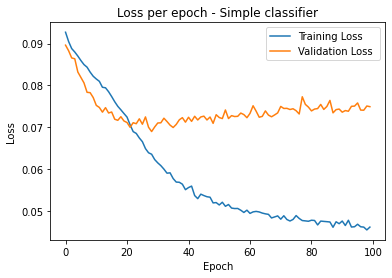

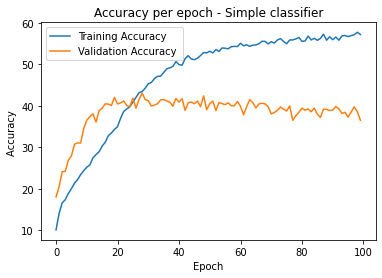

In [39]:
plt.rcParams["figure.figsize"] = (6,4)
plot_graph(stats[0],stats[2],NUM_EPOCS,"Loss ",name)
plot_graph(stats[1],stats[3],NUM_EPOCS,"Accuracy ",name)


Test loss: 2.2551 
Testing Accuracy: 816/2000 (40.80%)
apple Class Accuracy: 32/100 (32.00%)
banana Class Accuracy: 32/100 (32.00%)
bear Class Accuracy: 65/100 (65.00%)
bell_pepper Class Accuracy: 35/100 (35.00%)
bird Class Accuracy: 27/100 (27.00%)
broccoli Class Accuracy: 41/100 (41.00%)
cat Class Accuracy: 27/100 (27.00%)
cauliflower Class Accuracy: 16/100 (16.00%)
cow Class Accuracy: 61/100 (61.00%)
dog Class Accuracy: 10/100 (10.00%)
elephant Class Accuracy: 59/100 (59.00%)
fox Class Accuracy: 45/100 (45.00%)
goat Class Accuracy: 24/100 (24.00%)
horse Class Accuracy: 36/100 (36.00%)
mashed_potato Class Accuracy: 53/100 (53.00%)
orange Class Accuracy: 68/100 (68.00%)
pineapple Class Accuracy: 13/100 (13.00%)
pomegranate Class Accuracy: 48/100 (48.00%)
tomato Class Accuracy: 49/100 (49.00%)
zebra Class Accuracy: 75/100 (75.00%)
Classifier has Acc=0.408 P=0.408 R=0.427 F1=0.396
               precision    recall  f1-score   support

        apple       0.29      0.32      0.30      

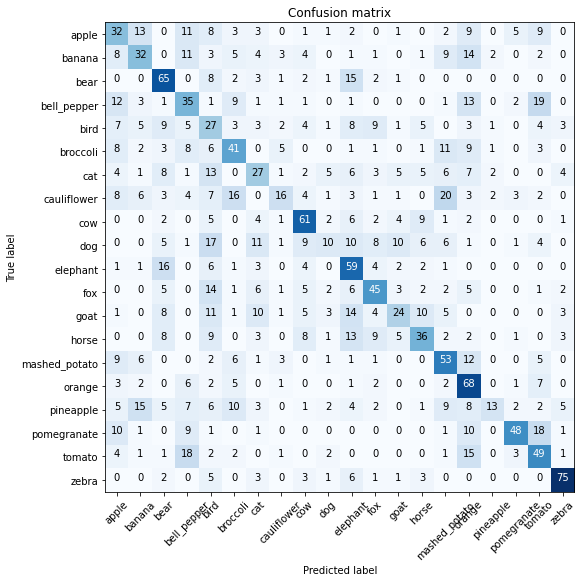

In [40]:
result = test_model(best_model, criterion, name)

### intermeddiate result

In [ ]:
best_model, stats = train_model(model, dataloaders_dict, criterion, optimizer, NUM_EPOCS, name, folder_name, DEBUG)

Epoch 31/50
-------------



train Loss: 0.0639 Acc: 42.9399



val Loss: 0.0711 Acc: 41.2546
-------------
Epoch 32/50
-------------



train Loss: 0.0630 Acc: 43.9571



val Loss: 0.0709 Acc: 40.8590
-------------
Epoch 33/50
-------------



train Loss: 0.0620 Acc: 44.3244



val Loss: 0.0708 Acc: 39.9548
-------------
Epoch 34/50
-------------



train Loss: 0.0612 Acc: 45.5534



val Loss: 0.0694 Acc: 41.5937
-------------
Epoch 35/50
-------------



train Loss: 0.0602 Acc: 46.5635



val Loss: 0.0706 Acc: 42.4696
-------------
Epoch 36/50
-------------



train Loss: 0.0609 Acc: 45.9066



val Loss: 0.0701 Acc: 42.6392
-------------
Epoch 37/50
-------------



train Loss: 0.0594 Acc: 46.9308



val Loss: 0.0698 Acc: 42.9500
-------------
Epoch 38/50
-------------



train Loss: 0.0586 Acc: 48.3012



val Loss: 0.0714 Acc: 41.1133
-------------
Epoch 39/50
-------------



train Loss: 0.0579 Acc: 48.3577



val Loss: 0.0715 Acc: 41.0568
-------------
Epoch 40/50
-------------



train Loss: 0.0580 Acc: 47.9198



val Loss: 0.0721 Acc: 40.6329
-------------
Epoch 41/50
-------------



train Loss: 0.0570 Acc: 48.7815



val Loss: 0.0722 Acc: 40.8307
-------------
Epoch 42/50
-------------



train Loss: 0.0560 Acc: 50.0883



val Loss: 0.0722 Acc: 39.8135
-------------
Epoch 43/50
-------------



train Loss: 0.0561 Acc: 49.9258



val Loss: 0.0721 Acc: 40.3221
-------------
Epoch 44/50
-------------



train Loss: 0.0556 Acc: 50.1872



val Loss: 0.0722 Acc: 40.3504
-------------
Epoch 45/50
-------------



train Loss: 0.0552 Acc: 50.2578



val Loss: 0.0714 Acc: 41.1416
-------------
Epoch 46/50
-------------



train Loss: 0.0556 Acc: 50.3002



val Loss: 0.0718 Acc: 41.5089
-------------
Epoch 47/50
-------------



train Loss: 0.0555 Acc: 50.2225



val Loss: 0.0720 Acc: 41.3111
-------------
Epoch 48/50
-------------



train Loss: 0.0541 Acc: 51.6352



val Loss: 0.0714 Acc: 41.6502
-------------
Epoch 49/50
-------------



train Loss: 0.0535 Acc: 51.8613



val Loss: 0.0715 Acc: 41.5089
-------------
Epoch 50/50
-------------



train Loss: 0.0531 Acc: 52.2145



val Loss: 0.0718 Acc: 40.7742
-------------
Lowest training loss 0.053082115852943104
Lowest validation loss 0.0693832337435237
Highest training accuracy 52.21445221445221
Highest validation accuracy 42.94998587171517
-------------


/content/drive/My Drive/Colab Notebooks/Graphs/04_simple_Loss _.png04_simple_Loss _.png
/content/drive/My Drive/Colab Notebooks/Graphs/04_simple_Accuracy _.png04_simple_Accuracy _.png


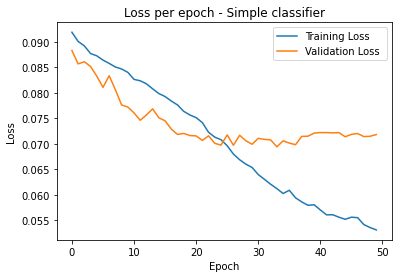

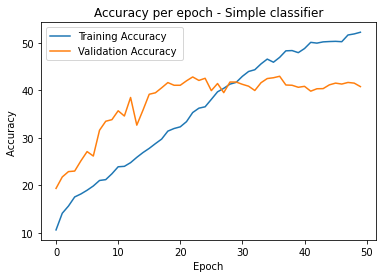

In [ ]:
plt.rcParams["figure.figsize"] = (6,4)
plot_graph(stats[0],stats[2],NUM_EPOCS,"Loss ",name)
plot_graph(stats[1],stats[3],NUM_EPOCS,"Accuracy ",name)


Test loss: 2.2560 
Testing Accuracy: 840/2000 (42.00%)
apple Class Accuracy: 11/100 (11.00%)
banana Class Accuracy: 38/100 (38.00%)
bear Class Accuracy: 54/100 (54.00%)
bell_pepper Class Accuracy: 37/100 (37.00%)
bird Class Accuracy: 20/100 (20.00%)
broccoli Class Accuracy: 40/100 (40.00%)
cat Class Accuracy: 29/100 (29.00%)
cauliflower Class Accuracy: 32/100 (32.00%)
cow Class Accuracy: 60/100 (60.00%)
dog Class Accuracy: 17/100 (17.00%)
elephant Class Accuracy: 61/100 (61.00%)
fox Class Accuracy: 59/100 (59.00%)
goat Class Accuracy: 26/100 (26.00%)
horse Class Accuracy: 23/100 (23.00%)
mashed_potato Class Accuracy: 57/100 (57.00%)
orange Class Accuracy: 53/100 (53.00%)
pineapple Class Accuracy: 48/100 (48.00%)
pomegranate Class Accuracy: 71/100 (71.00%)
tomato Class Accuracy: 33/100 (33.00%)
zebra Class Accuracy: 71/100 (71.00%)
Classifier has Acc=0.420 P=0.420 R=0.417 F1=0.410
               precision    recall  f1-score   support

        apple       0.22      0.11      0.15      

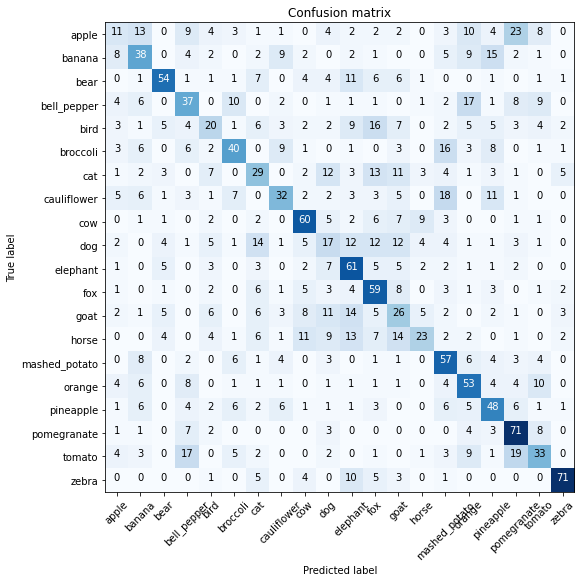

In [ ]:
result = test_model(best_model, criterion, name)